# Save Results of all Models for a given Data and Model Version

Loop over all Folds and Models and save the results in a dataframe.  
Calculate a threshold for outcome prediction on the validation data (based on geometric mean) and apply it to the test data.  
Add a normalized prediction uncertainty based on the standard deviation of the predictions of the different models.  


## Load Libraries and Modules

In [1]:
%matplotlib inline

import os
import h5py
import pandas as pd
import numpy as np
import pickle as pkl
import time

import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
from statsmodels.stats.proportion import proportion_confint
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras

print("TF  Version",tf.__version__)

Using TensorFlow backend.


TF  Version 2.2.0


In [2]:
# check and set path before loading modules
print(os.getcwd())
DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
if os.getcwd() != DIR:
    os.chdir(DIR)
    print(os.getcwd())

import functions_metrics as fm
import functions_model_definition as md
import functions_read_data as rdat
import Utils_maurice as utils

#ontram functions
from k_ontram_functions.ontram import ontram
from k_ontram_functions.ontram_loss import ontram_loss
from k_ontram_functions.ontram_metrics import ontram_acc, ontram_auc
from k_ontram_functions.ontram_predict import predict_ontram, get_parameters

#weights tuning functions
import ens_weights_tuning as w_tune

/tf
/tf/notebooks/schnemau/xAI_stroke_3d


## Let's look at some training

### Model 1 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


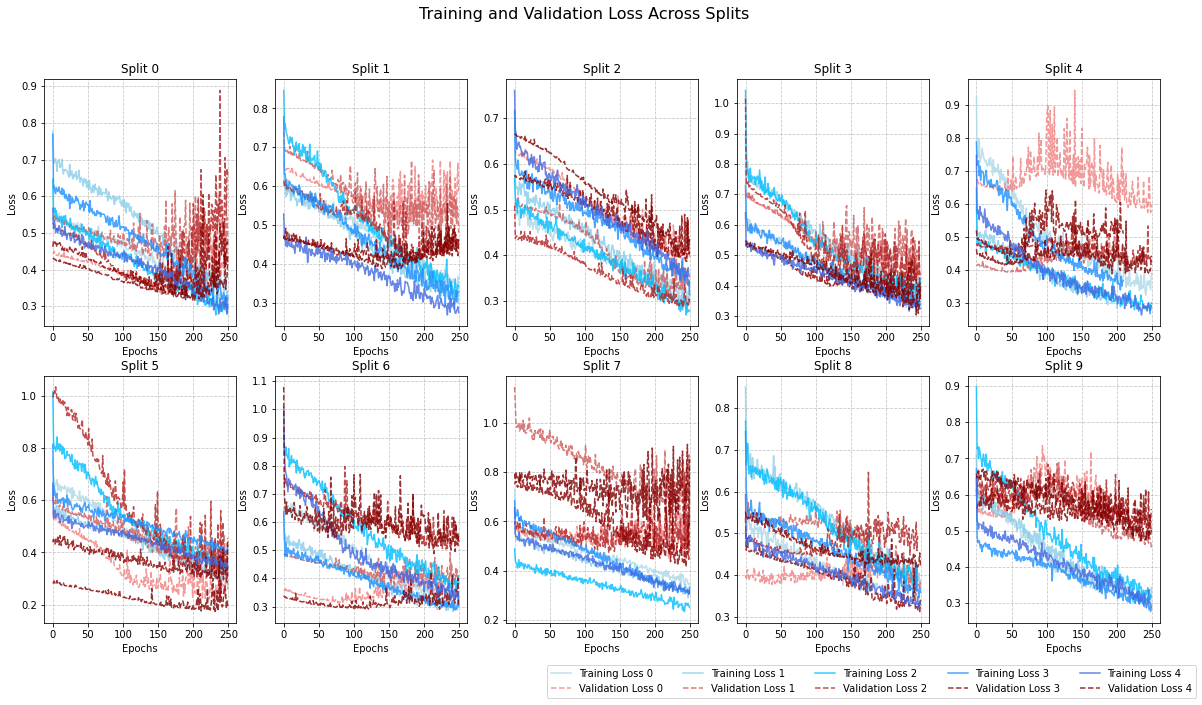

In [3]:
# Create subplots for all 10 splits
fig, axs = plt.subplots(2, 5, figsize=(20, 10))

last_activation = "linear"
model_version = 1

# Define shades of blue for training loss
train_loss_colors = ['lightblue', 'skyblue', 'deepskyblue', 'dodgerblue', 'royalblue']

# Define shades of red for validation loss
val_loss_colors = ['lightcoral', 'indianred', 'firebrick', 'darkred', 'maroon']

for which_split in range(10):
    # Determine subplot indices
    row, col = divmod(which_split, 5)

    # Access the current subplot
    ax = axs[row, col]

    # Iterate over models
    for i in range(5):
        model_name = f"/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX/hist_3d_cnn_binary_model_splitCIB_LSX{which_split}_normalized_avg_layer_paper_model_{last_activation}_activation_{model_version}_{i}.pkl"
                                                                                    
        # Load training history
        with open(model_name, "rb") as file:
            histplt = pkl.load(file)

        # Plot training history lines with different shades of blue for training loss
        ax.plot(histplt['loss'], label=f"Training Loss {i}", color=train_loss_colors[i], linestyle='-', alpha=0.8)
        
        # Plot validation history lines with different shades of red for validation loss
        ax.plot(histplt['val_loss'], label=f"Validation Loss {i}", color=val_loss_colors[i], linestyle='--', alpha=0.8)

    # Set plot labels and title for each subplot
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(f"Split {which_split}")

    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.7)

# Add a title for the entire graph
fig.suptitle("Training and Validation Loss Across Splits", fontsize=16)

# Add legend to the last subplot with adjusted location and layout
ax.legend(loc='upper center', bbox_to_anchor=(-0.5, -0.15), fancybox=True, ncol=5)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plot
plt.show()

### Model 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


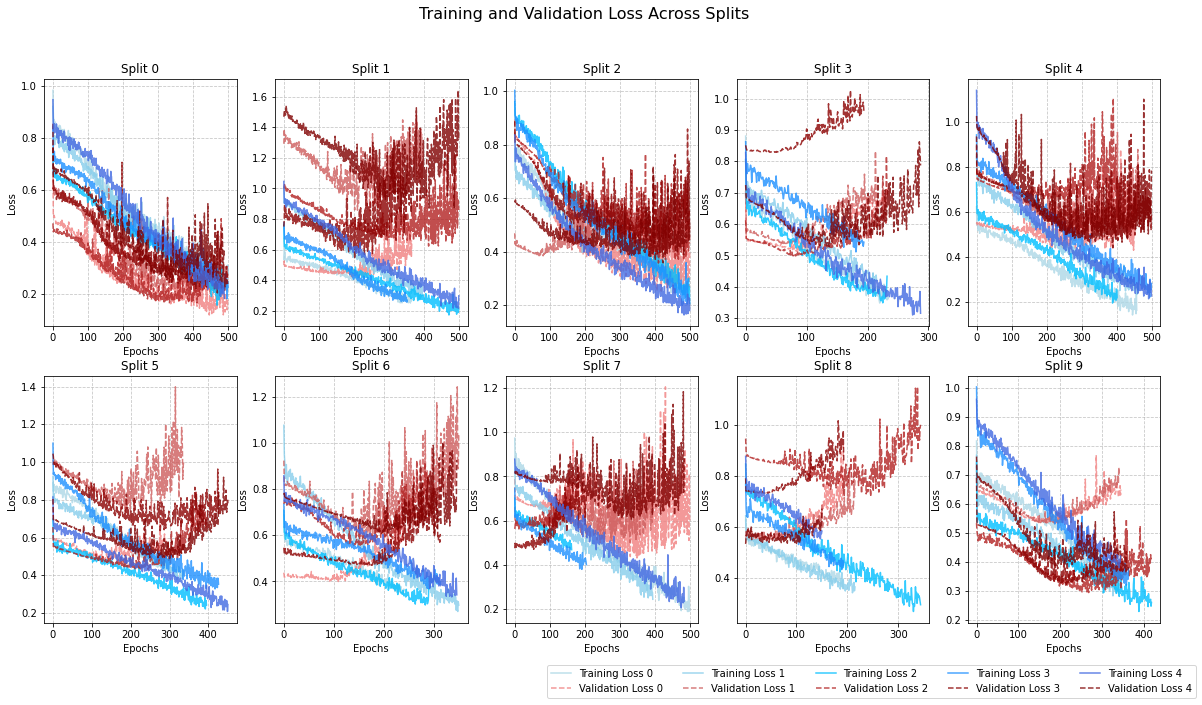

In [4]:
# Create subplots for all 10 splits
fig, axs = plt.subplots(2, 5, figsize=(20, 10))

model_version = 2

# Define shades of blue for training loss
train_loss_colors = ['lightblue', 'skyblue', 'deepskyblue', 'dodgerblue', 'royalblue']

# Define shades of red for validation loss
val_loss_colors = ['lightcoral', 'indianred', 'firebrick', 'darkred', 'maroon']

for which_split in range(10):
    # Determine subplot indices
    row, col = divmod(which_split, 5)

    # Access the current subplot
    ax = axs[row, col]

    # Iterate over models
    for i in range(5):
        model_name = f"/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX/hist_3D_CNN_avg_layer_binary_outcome_CIBLSX_split{which_split}_ens{i}_M2.pkl"
        # Load training history
        with open(model_name, "rb") as file:
            histplt = pkl.load(file)

        # Plot training history lines with different shades of blue for training loss
        ax.plot(histplt['loss'], label=f"Training Loss {i}", color=train_loss_colors[i], linestyle='-', alpha=0.8)
        
        # Plot validation history lines with different shades of red for validation loss
        ax.plot(histplt['val_loss'], label=f"Validation Loss {i}", color=val_loss_colors[i], linestyle='--', alpha=0.8)

    # Set plot labels and title for each subplot
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title(f"Split {which_split}")

    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.7)

# Add a title for the entire graph
fig.suptitle("Training and Validation Loss Across Splits", fontsize=16)

# Add legend to the last subplot with adjusted location and layout
ax.legend(loc='upper center', bbox_to_anchor=(-0.5, -0.15), fancybox=True, ncol=5)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plot
plt.show()


## Load Data and Results

In [5]:
version = "10Fold_CIBLSX" 
layer_connection = "globalAveragePooling" 
last_activation = "linear" 
# Define Model Version
model_version = 1

# should csv be saved?
save_file = True

DATA_OUTPUT_DIR = DIR + "data/"

In [6]:
# Setup the paths for the result assembly
DATA_DIR = DIR + "data/" 
WEIGHT_DIR = DIR + "weights/" + version + "/"
id_tab = pd.read_csv(DATA_DIR + "10Fold_ids_V0.csv", sep=",")
X = np.load(DATA_DIR + "prepocessed_dicom_3d.npy")
all_result_name = "all_tab_results_" + version + "_M" + str(model_version) 
which_splits = list(range(0,10)) # 10 Fold
print(id_tab.shape)
print(X.shape)

(407, 14)
(407, 128, 128, 28)


In [7]:
print(WEIGHT_DIR)
print(all_result_name)

/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX/
all_tab_results_10Fold_CIBLSX_M1


In [8]:
(X_train, X_valid, X_test),(X_tab_train, X_tab_valid, X_tab_test), (y_train, y_valid, y_test) = rdat.split_data_tabular(id_tab, X, 1)

input_dim = (128, 128, 28, 1)
output_dim = 1
batch_size = 6
C = 2 

mbl = utils.img_model_linear_final(input_dim, output_dim)
mls = utils.mod_linear_shift(X_tab_train.shape[1])
model_3d = ontram(mbl, mls)             

model_3d.compile(optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
                                loss=ontram_loss(C, batch_size),
                                metrics=[ontram_acc(C, batch_size)])

In [9]:
model_nrs = list(range(5)) #num of ensembles

In [10]:
results_list = [] # test dataset results
valid_list = [] # validation datset results
betas = [] # validation datset results
weights = []

for which_split in which_splits:
    (X_train, X_valid, X_test),(X_tab_train, X_tab_valid, X_tab_test), (y_train, y_valid, y_test) = rdat.split_data_tabular(id_tab, X, which_split)

    X_train = np.expand_dims(X_train, axis=-1)
    X_valid = np.expand_dims(X_valid, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)
    Y_train = to_categorical(y_train)
    Y_valid = to_categorical(y_valid)
    Y_test = to_categorical(y_test)
        
    test_data = tf.data.Dataset.from_tensor_slices((X_test, X_tab_test))
    test_labels = tf.data.Dataset.from_tensor_slices((Y_test))
    test_loader = tf.data.Dataset.zip((test_data, test_labels))
    test_dataset_pred = (test_loader.batch(len(X_test)))

    valid_data = tf.data.Dataset.from_tensor_slices((X_valid, X_tab_valid))
    valid_labels = tf.data.Dataset.from_tensor_slices((Y_valid))
    valid_loader = tf.data.Dataset.zip((valid_data, valid_labels))
    valid_dataset_pred = (valid_loader.batch(len(X_valid)))  
  
    results = id_tab[id_tab["fold" + str(which_split)] == "test"].copy()      
        
    results["test_split"] = which_split        
    
    validation_results = pd.DataFrame(
        {"test_split": which_split,
         "unfavorable": y_valid}
    )
       
    shift_params = []
    intercepts_test = []
    intercepts_val = []
    y_test_preds = []
    y_valid_preds = []

    for model_nr in model_nrs:        
        #model_name = ("/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX/3d_cnn_binary_model_split" + "CIB_LSX" + str(which_split) + 
        #                  "_normalized_avg_layer_paper_model_" + last_activation + 
        #                  "_activation_" + str(model_version) + "_" + str(model_nr) + ".h5")        
        

        model_name = ("/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_CIBLSX/3D_CNN_avg_layer_binary_outcome_CIBLSX_split"+str(which_split)+"_ens"+str(model_nr)+"_M2.h5")


        
        model_3d.load_weights(model_name)
        
        #test
        predic =  predict_ontram(model_3d, data = test_dataset_pred)['pdf'][:,1]
        y_test_preds.append(predic.squeeze())
        results["y_pred_model_" + str(model_nr)] = y_test_preds[-1]

        #valid
        predicc = predict_ontram(model_3d, data = valid_dataset_pred)['pdf'][:,1]
        y_valid_preds.append(predicc.squeeze())
        validation_results["y_pred_model_" + str(model_nr)] = y_valid_preds[-1]   

        #ensembling        
        shift_params.append(get_parameters(model_3d)['shift'][0][0][0])
        #test
        preds_test = model_3d.predict(test_dataset_pred)
        intercepts_test.append(preds_test[:, 0])
        #valid
        preds_val = model_3d.predict(valid_dataset_pred)
        intercepts_val.append(preds_val[:, 0])

    
    y_test_preds = np.array(y_test_preds)
    y_valid_preds = np.array(y_valid_preds)

    #first optimize weights based on validation set

    weigths_tuned = w_tune.get_w(intercepts = intercepts_val, shift = shift_params, 
                                 X_tab = X_tab_valid, y_true = y_valid, nens = len(model_nrs))
    
    for model_nr in model_nrs:
        results[f'weight_model_{model_nr}'] = weigths_tuned[model_nr]
        validation_results[f'weight_model_{model_nr}'] = weigths_tuned[model_nr]
    
    #calculate ensemble based on optimized weights and average weights

    results["y_pred_trafo_avg_w"] = w_tune.get_ensemble(intercepts_test, shift_params, 
                                                      X_tab_test, weights=weigths_tuned, n_ens=len(model_nrs))
    
    results["y_pred_trafo_avg"] = w_tune.get_ensemble(intercepts_test, shift_params, 
                                                      X_tab_test, weights=None, n_ens=len(model_nrs))
    
    results["y_pred_image_only_w"] = w_tune.get_ensemble_CIB(intercepts_test, weights=weigths_tuned, n_ens=len(model_nrs)) 
    
    results["y_pred_image_only_avg"] = w_tune.get_ensemble_CIB(intercepts_test, weights=None, n_ens=len(model_nrs)) 
       
    validation_results["y_pred_trafo_avg_w"] = w_tune.get_ensemble(intercepts_val, shift_params, 
                                                                 X_tab_valid, weights=weigths_tuned, n_ens=len(model_nrs))
    
    validation_results["y_pred_trafo_avg"] = w_tune.get_ensemble(intercepts_val, shift_params, 
                                                                 X_tab_valid, weights=None, n_ens=len(model_nrs))
    
    weights.append(weigths_tuned)
    results_list.append(results)
    valid_list.append(validation_results)
    

ResourceExhaustedError:  OOM when allocating tensor with shape[41,128,128,28,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node mod_ontram/conv3d/Conv3D (defined at /tf/notebooks/schnemau/xAI_stroke_3d/k_ontram_functions/ontram_predict.py:14) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_402]

Function call stack:
predict_function


In [10]:
results_list[2].head(5)

,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,fold5,...,y_pred_model_4,weight_model_0,weight_model_1,weight_model_2,weight_model_3,weight_model_4,y_pred_trafo_avg_w,y_pred_trafo_avg,y_pred_image_only_w,y_pred_image_only_avg
14,15,22,0.0,0,train,train,test,train,train,train,...,0.147794,0.269674,0.064265,0.507903,0.0,0.158158,0.140372,0.126379,0.083907,0.074360
19,20,27,2.0,0,train,train,test,train,train,train,...,0.221258,0.269674,0.064265,0.507903,0.0,0.158158,0.393675,0.314891,0.119695,0.097664
36,37,48,0.0,0,train,train,test,train,train,train,...,0.022725,0.269674,0.064265,0.507903,0.0,0.158158,0.017464,0.016998,0.036270,0.046187
45,46,59,0.0,0,train,train,test,train,train,train,...,0.008720,0.269674,0.064265,0.507903,0.0,0.158158,0.005791,0.009071,0.017251,0.027582
46,47,60,3.0,1,train,train,test,train,train,train,...,0.920173,0.269674,0.064265,0.507903,0.0,0.158158,0.143686,0.239344,0.151808,0.172610


In [11]:
valid_list[2].head(5)

,test_split,unfavorable,y_pred_model_0,y_pred_model_1,y_pred_model_2,y_pred_model_3,y_pred_model_4,weight_model_0,weight_model_1,weight_model_2,weight_model_3,weight_model_4,y_pred_trafo_avg_w,y_pred_trafo_avg
0,2,0,0.616272,0.372637,0.780007,0.405162,0.279080,0.269674,0.064265,0.507903,0.0,0.158158,0.642686,0.494276
1,2,0,0.143765,0.119070,0.311546,0.020859,0.157959,0.269674,0.064265,0.507903,0.0,0.158158,0.218027,0.117101
2,2,0,0.060601,0.061698,0.115220,0.191823,0.123698,0.269674,0.064265,0.507903,0.0,0.158158,0.094569,0.101610
3,2,0,0.021747,0.067108,0.012541,0.018792,0.010874,0.269674,0.064265,0.507903,0.0,0.158158,0.015882,0.020754
4,2,1,0.158761,0.047635,0.036018,0.045527,0.191926,0.269674,0.064265,0.507903,0.0,0.158158,0.073167,0.076841


In [12]:
weights[2]

array([0.26967439, 0.06426459, 0.50790274, 0.        , 0.15815828])

## Calculate Threshold

Calculation of threshold for classification is done on validation data. Then applied to the test data.

In [13]:
valid_thresholds_avg = []
valid_thresholds_avg_w = []

for i, validation_results in enumerate(valid_list):
  
    y_org = validation_results["unfavorable"]
    y_pred_avg = validation_results["y_pred_trafo_avg"]
    y_pred_avg_w = validation_results["y_pred_trafo_avg_w"]
  
    # calculate fpr, tpr and thresholds
    fpr, tpr, threshold = metrics.roc_curve(y_org, y_pred_avg)
    fpr_w, tpr_w, threshold_w = metrics.roc_curve(y_org, y_pred_avg_w)

    #auc
    roc_auc = metrics.auc(fpr, tpr)
    roc_auc_w = metrics.auc(fpr_w, tpr_w)
    
    # calculate geometric mean of tpr and fpr to find best threshold
    gmean = np.sqrt(tpr * (1 - fpr))
    gmean_w = np.sqrt(tpr_w * (1 - fpr_w))

    # Find the optimal threshold
    index = np.argmax(gmean)
    index_w = np.argmax(gmean_w)

    valid_thresholds_avg.append(threshold[index])
    valid_thresholds_avg_w.append(threshold_w[index_w])

### Apply Threshold to Testdata

In [14]:
for i, results in enumerate(results_list):
    results["threshold_avg"] = valid_thresholds_avg[i]
    results["threshold_avg_w"] = valid_thresholds_avg_w[i]
    
    results["y_pred_class_avg"] = (results["y_pred_trafo_avg"] >= results["threshold_avg"]).astype(int)
    results["y_pred_class_avg_w"] = (results["y_pred_trafo_avg_w"] >= results["threshold_avg_w"]).astype(int)


#### Concat all Pandas and Analyze

In [15]:
all_results = pd.concat(results_list)
all_results

,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,fold5,...,weight_model_3,weight_model_4,y_pred_trafo_avg_w,y_pred_trafo_avg,y_pred_image_only_w,y_pred_image_only_avg,threshold_avg,threshold_avg_w,y_pred_class_avg,y_pred_class_avg_w
13,14,21,1.0,0,test,train,train,train,train,val,...,0.347004,0.331860,0.008119,0.010045,0.024083,0.023049,0.195370,0.139736,0,0
26,27,36,0.0,0,test,train,train,train,train,val,...,0.347004,0.331860,0.080171,0.078780,0.100629,0.107277,0.195370,0.139736,0,0
27,28,38,2.0,0,test,train,train,train,train,val,...,0.347004,0.331860,0.103622,0.071203,0.084395,0.076433,0.195370,0.139736,0,0
33,34,44,1.0,0,test,train,train,train,train,val,...,0.347004,0.331860,0.177907,0.188954,0.252949,0.225474,0.195370,0.139736,0,1
34,35,46,0.0,0,test,train,train,train,train,val,...,0.347004,0.331860,0.006481,0.008405,0.015955,0.016969,0.195370,0.139736,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,345,486,0.0,0,train,train,train,train,val,train,...,0.106470,0.225948,0.141070,0.166124,0.189729,0.204031,0.219728,0.246881,0,0
369,370,514,3.0,1,train,train,train,train,val,train,...,0.106470,0.225948,0.046099,0.056816,0.042513,0.049844,0.219728,0.246881,0,0
393,394,541,0.0,0,train,train,train,train,val,train,...,0.106470,0.225948,0.022853,0.025886,0.064714,0.085542,0.219728,0.246881,0,0
396,397,546,1.0,0,train,train,train,train,val,train,...,0.106470,0.225948,0.026324,0.027449,0.042304,0.044276,0.219728,0.246881,0,0


### Roc Curve 

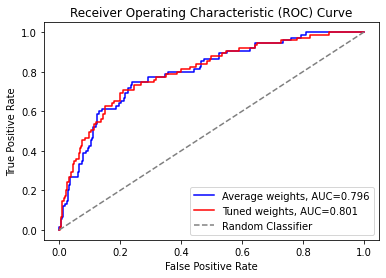

In [16]:
import matplotlib.pyplot as plt
from sklearn import metrics

y_test = all_results["unfavorable"]
y_pred_proba = all_results["y_pred_trafo_avg"]

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

# Plot the first ROC curve
plt.plot(fpr, tpr, label="Average weights, AUC="+str(round(auc,3)), color = "blue")

# Assuming all_results2 is your second DataFrame
y_test2 = all_results["unfavorable"]
y_pred_proba2 = all_results["y_pred_trafo_avg_w"]

fpr2, tpr2, _ = metrics.roc_curve(y_test2, y_pred_proba2)
auc2 = metrics.roc_auc_score(y_test2, y_pred_proba2)

# Plot the second ROC curve
plt.plot(fpr2, tpr2, label="Tuned weights, AUC="+str(round(auc2,3)), color='red')

# Add the line for a random classifier
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Classifier')

# Customize the plot
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

### Metrics analysis

In [17]:
y_true = all_results["unfavorable"]
y_pred_binary = all_results["y_pred_class_avg"]
y_pred_binary_w = all_results["y_pred_class_avg_w"]

y_pred_trafo_avg = all_results["y_pred_trafo_avg"]
y_pred_trafo_avg_w = all_results["y_pred_trafo_avg_w"]

# Calculate metrics average weighted
f1_value = metrics.f1_score(y_true, y_pred_binary)
sensitivity = metrics.recall_score(y_true, y_pred_binary)
specificity = metrics.recall_score(y_true, y_pred_binary, pos_label=0)
auc_value = metrics.roc_auc_score(y_true, y_pred_trafo_avg)
log_li = metrics.log_loss(y_true, y_pred_trafo_avg)

# Calculate metrics tuned weighted average
f1_value_w = metrics.f1_score(y_true, y_pred_binary_w)
sensitivity_w = metrics.recall_score(y_true, y_pred_binary_w)
specificity_w = metrics.recall_score(y_true, y_pred_binary_w, pos_label=0)
auc_value_w = metrics.roc_auc_score(y_true, y_pred_trafo_avg_w)
log_li_w = metrics.log_loss(y_true, y_pred_trafo_avg_w)

# Display results 1
print("---Trafo Average:---")
print("F1-Value:", round(f1_value,4))
print("Sensitivity:", round(sensitivity,4))
print("Specificity:", round(specificity,4))
print("AUC:", round(auc_value,4))
print("Negative Log-Likelihood:", round(log_li,4))

print("---------------------------------------------")

# Display results 2
print("---Trafo Average weighted tuned:---")
print("F1-Value:", round(f1_value_w,4))
print("Sensitivity:", round(sensitivity_w,4))
print("Specificity:", round(specificity_w,4))
print("AUC:", round(auc_value_w,4))
print("Negative Log-Likelihood:", round(log_li_w,4))

---Trafo Average:---
F1-Value: 0.5111
Sensitivity: 0.6133
Specificity: 0.8223
AUC: 0.7956
Negative Log-Likelihood: 0.3989
---------------------------------------------
---Trafo Average weighted tuned:---
F1-Value: 0.4876
Sensitivity: 0.6533
Specificity: 0.7681
AUC: 0.8008
Negative Log-Likelihood: 0.3924


## Calculate Model Uncertainty

Use the standard deviation of the predictions as a measure of uncertainty. Then use min max normalization to scale the uncertainty between 0 and 1.  
Compare the uncertainty with the predictions

In [18]:
all_results["y_pred_std"] = all_results[["y_pred_model_" + str(i) for i in range(5)]].std(axis = 1)
all_results["y_pred_unc"] = (all_results["y_pred_std"] - all_results.y_pred_std.min()) / (
    all_results.y_pred_std.max() - all_results.y_pred_std.min())

### weighted

In [19]:
weighted_means = np.average(all_results[["y_pred_model_" + str(i) for i in range(5)]],
                            weights=all_results[["weight_model_" + str(i) for i in range(5)]],
                            axis=1)

weighted_var = np.average((all_results[["y_pred_model_" + str(i) for i in range(5)]] - weighted_means[:, np.newaxis])**2,
                                         weights=all_results[["weight_model_" + str(i) for i in range(5)]],
                                         axis=1)

all_results["y_pred_std_w"] = np.sqrt(weighted_var)

all_results["y_pred_unc_w"] = (all_results["y_pred_std_w"] - all_results["y_pred_std_w"].min()) / (
        all_results["y_pred_std_w"].max() - all_results["y_pred_std_w"].min())

### plotting uncertaintiy

[Text(0, 0.5, 'prediction uncertainty'), Text(0.5, 0, 'true class')]

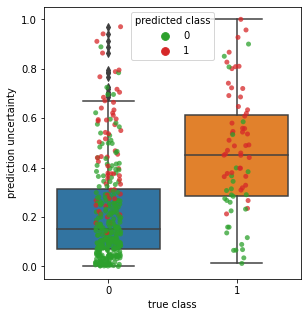

In [20]:
# Plot uncertainty
plt.figure(figsize = (4.6,5))
sns.boxplot(x = "unfavorable",
    y = "y_pred_unc",
    data = all_results)
g = sns.stripplot(x = "unfavorable",
    y = "y_pred_unc",
    hue = 'y_pred_class_avg',
    alpha = 0.75,
    palette=["C2", "C3"],
    data = all_results)
plt.legend(title='predicted class', loc='upper center')
g.set(xlabel='true class', ylabel='prediction uncertainty')

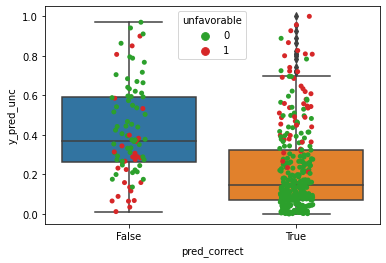

In [21]:
all_results["pred_correct"] = all_results["y_pred_class_avg"] == all_results["unfavorable"] 
all_results["pred_correct_w"] = all_results["y_pred_class_avg_w"] == all_results["unfavorable"] 

sns.boxplot(x = "pred_correct",
    y = "y_pred_unc",
    data = all_results)
sns.stripplot(x = "pred_correct",
    y = "y_pred_unc",
    hue = 'unfavorable',
    palette=["C2", "C3"],
    data = all_results)

### Save results

Delete threshold 1 because mulitple different thresholds does not make sense.

In [22]:
DATA_OUTPUT_DIR + all_result_name + ".csv"

'/tf/notebooks/schnemau/xAI_stroke_3d/data/all_tab_results_10Fold_CIBLSX_M1.csv'

In [23]:
save_file = True
if save_file:
    all_results.to_csv(DATA_OUTPUT_DIR + all_result_name + ".csv",  index=False) 